<a href="https://colab.research.google.com/github/janljubas/OReL/blob/main/HA5/LunarLanderDQN2025Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lunar lander with DQN-style neural function approximator using PyTorch
### Christian Igel, 2025

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

I took inspiration from https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb.

Imports:

In [1]:
import gymnasium as gym

from tqdm.notebook import tqdm  # Progress bar

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379495 sha256=70e05f6e24b145da130a365a876f71cafb001349976b4918a562ea058e8d4205
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


Create the game environment (you need the `gym` package):

In [4]:
env_visual = gym.make('LunarLander-v3', render_mode="human")
action_size = 4
state_size = 8

Let's just test the environment first:

In [5]:
test_episodes = 0
for _ in range(test_episodes):
    R = 0
    state, _ = env_visual.reset()  # Environment starts in a random state, cart and pole are moving
    print("initial state:", state)
    while True:  # Environment sets "truncated" to true after 500 steps
        env_visual.render()
        state, reward, terminated, truncated, _ = env_visual.step(env_visual.action_space.sample()) #  Take a random action
        R += reward  # Accumulate reward
        if terminated or truncated:
            print("return: ", R)
            env_visual.reset()
            break

In [ ]:
#env.close()  # Closes the visualization window

Define *Q* network architecture:

In [6]:
class QNetwork(nn.Module):
    def __init__(self, state_size=8, action_size=4, hidden_size=10, bias=True):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size, bias)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias)
        self.output_layer = nn.Linear(hidden_size + state_size, action_size, bias)

    def forward(self, x_input):
        x = F.tanh(self.fc1(x_input))
        x = F.tanh(self.fc2(x))
        x = torch.cat((x_input, x), dim=1)
        x = self.output_layer(x)
        return x

Data structure for storing experiences:

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Define basic constants:

In [8]:
train_episodes = 400           # Max number of episodes to learn from
gamma = 0.99                   # Future reward discount
learning_rate = 0.001          # Q-network learning rate
tau = .01                      # learning rate for target network

# Exploration parameters
explore_start = 1.0            # Exploration probability at start
explore_stop = 0.0001          # Minimum exploration probability
decay_rate = 0.05              # Exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # Number of units in each Q-network hidden layer

# Memory parameters
memory_size = 10000            # Memory capacity
batch_size = 128               # Experience mini-batch size
pretrain_length = batch_size   # Number experiences to pretrain the memory

log_path = "/tmp/deep_Q_network"

Instantiate network:

In [9]:
mainQN = QNetwork(hidden_size=hidden_size)
print(mainQN)

QNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=72, out_features=4, bias=True)
)


Initialize the experience memory:

In [10]:
# Initialize the simulation
env = gym.make('LunarLander-v3')
state = env.reset()[0]

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in tqdm(range(pretrain_length)):
    # Make a random action
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        # The simulation fails, so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))

        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

  0%|          | 0/128 [00:00<?, ?it/s]

Now train with experiences:

In [12]:
total_reward_list = []  # Returns for the individual episodes

optimizer = torch.optim.AdamW(mainQN.parameters(), lr=learning_rate) # AdamW uses weight decay by default
loss_fn = torch.nn.MSELoss()

for ep in range(train_episodes):
    total_reward = 0  # Return / accumulated rewards
    state = env.reset()[0]  # Reset and get initial state
    while True:
        # Explore or exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*ep)
        if explore_p > np.random.rand():
            # Pick a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            state_tensor = torch.from_numpy(np.resize(state, (1, state_size)).astype(np.float32))
            Qs = mainQN(state_tensor)
            action = torch.argmax(Qs).item()

        # Take action, get new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)

        total_reward += reward  # Return / accumulated rewards

        if terminated or truncated:
            # Episode ends because of failure, so no next state
            next_state = np.zeros(state.shape)

            print('Episode: {}'.format(ep), 'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss), 'Explore P: {:.4f}'.format(explore_p))
            total_reward_list.append((ep, total_reward))

            # Add experience to memory
            memory.add((state, action, reward, next_state))
            break; # End of episode
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state

        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        next_states_np = np.array([each[3] for each in batch], dtype=np.float32)
        next_states = torch.as_tensor(next_states_np)  # as_tensor does not copy the data
        rewards     = torch.as_tensor(np.array([each[2] for each in batch], dtype=np.float32))
        states      = torch.as_tensor(np.array([each[0] for each in batch], dtype=np.float32))
        actions     = torch.as_tensor(np.array([each[1] for each in batch]))

        # Compute Q values for all actions in the new state
        target_Qs = mainQN(next_states)

        # Set target_Qs to 0 for states where episode ended because of failure
        episode_ends = (next_states_np == np.zeros(states[0].shape)).all(axis=1)
        target_Qs[episode_ends] = torch.zeros(action_size)

        # Compute targets
        y = rewards + gamma * torch.max(target_Qs, dim=1)[0].detach()

        # Network learning starts here
        optimizer.zero_grad()

        # Compute the Q values of the actions taken
        main_Qs = mainQN(states)  # Q values for all action in each state
        Q = torch.gather(main_Qs, 1, actions.unsqueeze(-1)).squeeze()  # Only the Q values for the actions taken

        # Gradient-based update
        loss = loss_fn(Q, y)
        loss.backward()
        optimizer.step()

Episode: 0 Total reward: -129.40115955975818 Training loss: 71.0340 Explore P: 1.0000
Episode: 1 Total reward: -131.44642223933715 Training loss: 4.8685 Explore P: 0.9512
Episode: 2 Total reward: -165.29388944483674 Training loss: 60.9477 Explore P: 0.9048
Episode: 3 Total reward: -139.66991002670716 Training loss: 50.3710 Explore P: 0.8607
Episode: 4 Total reward: -116.49691339820453 Training loss: 2.9189 Explore P: 0.8187
Episode: 5 Total reward: -263.9444100837336 Training loss: 11.6934 Explore P: 0.7788
Episode: 6 Total reward: -79.49454864946743 Training loss: 13.7083 Explore P: 0.7408
Episode: 7 Total reward: -384.0684114947823 Training loss: 6.0193 Explore P: 0.7047
Episode: 8 Total reward: -135.98029278408737 Training loss: 42.9111 Explore P: 0.6704
Episode: 9 Total reward: -406.06992458472354 Training loss: 42.6969 Explore P: 0.6377
Episode: 10 Total reward: -190.40219457598 Training loss: 3.8801 Explore P: 0.6066
Episode: 11 Total reward: -280.69115488592354 Training loss: 65

Save policy network:

In [13]:
torch.save(mainQN, log_path)

Plot learning process:

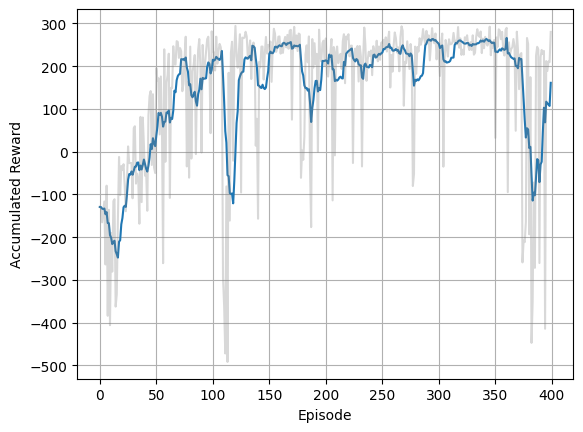

In [14]:
# Moving average for smoothing plot
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, x[0]*np.ones(N)))
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(total_reward_list).T
smoothed_rews = running_mean(rews, 10)

plt.plot(eps, smoothed_rews)
plt.grid()
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.savefig('deepQ.pdf')

Evaluate stored policy:

In [15]:
testQN = torch.load(log_path)

test_episodes = 5

for ep in range(test_episodes):
    state = env_visual.reset()[0]
    print("initial state:", state)
    R = 0
    while True:
        # Get action from Q-network
        # Hm, the following line could perhaps be more elegant ...
        state_tensor = torch.from_numpy(np.resize(state, (1, state_size)).astype(np.float32))
        Qs = testQN(state_tensor)
        action = torch.argmax(Qs).item()

        # Take action, get new state and reward
        next_state, reward, terminated, truncated, _ = env_visual.step(action)
        R += reward

        if terminated or truncated:
            print("reward:", R)
            break
        else:
            state = next_state


<ipython-input-15-3934a7995443>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testQN = torch.load(log_path)


initial state: [ 0.00233984  1.4051318   0.2369885  -0.2572509  -0.00270453 -0.05368137
  0.          0.        ]
reward: 210.52597882163656
initial state: [-0.00261059  1.4020138  -0.2644393  -0.39583194  0.00303179  0.05989935
  0.          0.        ]
reward: -249.47878803297095
initial state: [ 0.00478449  1.4216473   0.48458767  0.47675607 -0.0055371  -0.10976638
  0.          0.        ]
reward: 233.2319565792211
initial state: [ 1.4205932e-03  1.4221874e+00  1.4387596e-01  5.0076878e-01
 -1.6393228e-03 -3.2589965e-02  0.0000000e+00  0.0000000e+00]
reward: 159.771609579958
initial state: [-0.00714073  1.4216214  -0.7232951   0.4755879   0.00828113  0.16383715
  0.          0.        ]
reward: -34.43957665158479
